In [650]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import string
import re
from unidecode import unidecode
import pandas as pd
import nltk
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.decomposition import TruncatedSVD
import optuna
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler,StandardScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from textblob import TextBlob

In [651]:
tqdm.pandas()

In [652]:
# setting LOKY_MAX_CPU_COUNT to the number of cores you want to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

In [653]:
train_df = pd.read_csv(os.path.join(".","data","training_data.csv"))
test_df = pd.read_csv(os.path.join(".","data","testing_data.csv"))

In [654]:
train_df.head()

,id,Date,review ID,reviewer ID,product ID,rating_Helpful,rating_Thanks,rating_LoveThis,rating_OhNo,reviews,Label
0,0,5/17/2009,0dFa6egshOwhusL8aSMw-Q,8GC6cFcby0stKarnzL9i2w,dKcO9OQ44RPRlkWe-vToFA,0,0,0,4,Just got back from Shaw's. Great oysters. They...,Y
1,1,10/25/2011,htQgJ_Z0ADA_QHeKthfeFw,88KSdQ5IMdpCkOidmq1udg,NkOir65b_YAAQVlJR_zmJA,0,0,0,2,Back from friday & saturday nite stays in King...,Y
2,2,8/23/2009,2RsvT8p0SuAC25bhAi3EIw,bMKlvA-zWF4jU3OJCVbVlA,cQnY_VneZisfUAqcbuEuKg,0,0,0,5,It is a beautiful Saturday afternoon and my wi...,N
3,3,10/28/2011,LM-zONQMUNnAuf6NBISrow,9DMoXd0afrTIdpcwcDDVsw,WBU0yq9J8qiYQfI_fh2P1Q,0,1,1,5,A friend told me about this place but I have t...,N
4,4,6/18/2010,-DoQeDcNYFdmhOYcgx2MjQ,PyUn2FeMuLdmyB6xxMe4NA,-pO0hsi0xlF4FwqLGJUizg,0,2,0,5,I went to Uncommon Ground for brunch on a Sund...,N


In [655]:
print(f'Training shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

Training shape: (47176, 11)
Test shape: (20219, 10)


In [656]:
train_df.describe()

,id,rating_Helpful,rating_Thanks,rating_LoveThis,rating_OhNo
count,47176.000000,47176.000000,47176.000000,47176.000000,47176.000000
mean,23587.500000,0.454871,0.533852,0.842653,3.934352
std,13618.682486,1.645472,1.567664,1.930960,1.128047
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11793.750000,0.000000,0.000000,0.000000,3.000000
50%,23587.500000,0.000000,0.000000,0.000000,4.000000
75%,35381.250000,0.000000,1.000000,1.000000,5.000000
max,47175.000000,78.000000,68.000000,78.000000,5.000000


In [657]:
train_df.isnull().sum()

id                 0
Date               0
review ID          0
reviewer ID        0
product ID         0
rating_Helpful     0
rating_Thanks      0
rating_LoveThis    0
rating_OhNo        0
reviews            0
Label              0
dtype: int64

<Axes: xlabel='Label', ylabel='count'>

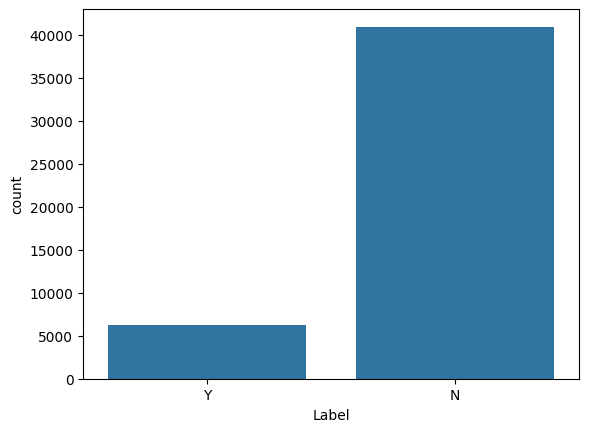

In [658]:
sns.countplot(data=train_df,x="Label")

In [659]:
train_df["Date"] = pd.to_datetime(train_df["Date"])

In [660]:
train_df["langth"] = train_df["reviews"].apply(len)

### Text Cleaning

In [590]:
def handleRepetitive(sentence):
    rx = re.compile(r'([^\W\d_])\1{2,}')
    return re.sub(r'[^\W\d_]+', lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(), sentence)

def replaceHomoglyphs(text):
    return unidecode(text)

def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '[URL]', text)

def remove_html(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_emails(text):
    canonical_email = re.sub(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)','[EMAIL]', text)
    return canonical_email

def convertLowercase(text):
    return text.lower()

def remove_numbers(text):
    return re.sub(r'\d+', '[NUMBER]', text)

stop_words = set(nltk.corpus.stopwords.words("english"))
def removeStopWords(text):
    text = [word for word in text.split() if word not in stop_words]
    return ' '.join(text)

spetial_chars = string.punctuation
escaped_chars = [re.escape(c) for c in spetial_chars]
spetial_chars_regex = re.compile(f"({'|'.join(escaped_chars)})")

def remove_punctuation(text):
    return re.sub(spetial_chars_regex," ",text)

stemmer = nltk.stem.SnowballStemmer(language="english")

def stem(text):
    
    text = nltk.word_tokenize(text, language='english')
        
    text = [stemmer.stem(word) for word in text]
    
    return ' '.join(text)

In [591]:
def clean_text(text):
    text = remove_punctuation(text)
    text = handleRepetitive(text)
    text = replaceHomoglyphs(text)
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_emails(text)
    text = remove_numbers(text)
    text = convertLowercase(text)
    text = removeStopWords(text)
    return text

In [592]:
train_df["cleaned_reviews"] = train_df["reviews"].progress_apply(clean_text)

  0%|          | 0/47176 [00:00<?, ?it/s]

In [593]:
train_df.to_csv(os.path.join("data/clean_train.csv"),index=False)

# Models

In [661]:
train_df = pd.read_csv("./data/clean_train.csv")

In [662]:
train_df['Label']=train_df['Label'].apply(lambda x: 1 if x=='Y' else 0)
train_df.head(3)

,id,Date,review ID,reviewer ID,product ID,rating_Helpful,rating_Thanks,rating_LoveThis,rating_OhNo,reviews,Label,langth,cleaned_reviews
0,0,2009-05-17,0dFa6egshOwhusL8aSMw-Q,8GC6cFcby0stKarnzL9i2w,dKcO9OQ44RPRlkWe-vToFA,0,0,0,4,Just got back from Shaw's. Great oysters. They...,1,170,got back shaw great oysters like [number] vari...
1,1,2011-10-25,htQgJ_Z0ADA_QHeKthfeFw,88KSdQ5IMdpCkOidmq1udg,NkOir65b_YAAQVlJR_zmJA,0,0,0,2,Back from friday & saturday nite stays in King...,1,672,back friday saturday nite stays king deluxe ro...
2,2,2009-08-23,2RsvT8p0SuAC25bhAi3EIw,bMKlvA-zWF4jU3OJCVbVlA,cQnY_VneZisfUAqcbuEuKg,0,0,0,5,It is a beautiful Saturday afternoon and my wi...,0,2655,beautiful saturday afternoon wife home two you...


# Feature extraction

In [663]:
def FeatureExtraction(df):
    reviewer_frequency = df.groupby('reviewer ID')['review ID'].count().reset_index()
    reviewer_frequency.columns = ['reviewer ID', 'review_frequency']

    ratios = df.groupby('reviewer ID').agg({
        'rating_Helpful': lambda x: sum(x) / len(x),
        'rating_Thanks': lambda x: sum(x) / len(x),
        'rating_LoveThis': lambda x: sum(x) / len(x),
        'review ID': 'count'
    }).reset_index()
    ratios.columns = ['reviewer ID', 'helpful_ratio', 'thanks_ratio', 'love_ratio', 'total_reviews']

    reviewer_behavior = pd.merge(reviewer_frequency, ratios, on='reviewer ID')

    # Calculate number of reviews per product
    product_reviews_count = df.groupby('product ID')['review ID'].count().reset_index()
    product_reviews_count.columns = ['product ID', 'reviews_count']
    
    rating_weights = {'rating_Helpful': 1, 'rating_Thanks': 1, 'rating_LoveThis': 1, 'rating_OhNo': -1}
    
    # Calculate overall rating for each product
    df['overall_rating'] = df.apply(lambda row: sum(row[rating] * rating_weights[rating] for rating in rating_weights.keys()), axis=1)
    
    # Calculate average rating per product
    product_avg_rating = df.groupby('product ID')['overall_rating'].mean().reset_index()
    product_avg_rating.columns = ['product ID', 'avg_rating']
    
    # Merge the two dataframes
    product_popularity = pd.merge(product_reviews_count, product_avg_rating, on='product ID')

    df = pd.merge(df, reviewer_behavior, on='reviewer ID')

    df = pd.merge(df, product_popularity, on='product ID')

    pol = lambda x: TextBlob(x).sentiment.polarity
    sub = lambda x: TextBlob(x).sentiment.subjectivity

    df['polarity'] = df['reviews'].progress_apply(pol)
    df['subjectivity'] = df['reviews'].progress_apply(sub)

    return df

In [664]:
train_df = FeatureExtraction(train_df)

  0%|          | 0/47176 [00:00<?, ?it/s]

  0%|          | 0/47176 [00:00<?, ?it/s]

In [665]:
train_df.head(3)

,id,Date,review ID,reviewer ID,product ID,rating_Helpful,rating_Thanks,rating_LoveThis,rating_OhNo,reviews,...,overall_rating,review_frequency,helpful_ratio,thanks_ratio,love_ratio,total_reviews,reviews_count,avg_rating,polarity,subjectivity
0,0,2009-05-17,0dFa6egshOwhusL8aSMw-Q,8GC6cFcby0stKarnzL9i2w,dKcO9OQ44RPRlkWe-vToFA,0,0,0,4,Just got back from Shaw's. Great oysters. They...,...,-4,1,0.000000,0.0,0.000000,1,431,-2.932715,0.420000,0.440000
1,1,2011-10-25,htQgJ_Z0ADA_QHeKthfeFw,88KSdQ5IMdpCkOidmq1udg,NkOir65b_YAAQVlJR_zmJA,0,0,0,2,Back from friday & saturday nite stays in King...,...,-2,1,0.000000,0.0,0.000000,1,212,-2.108491,0.058850,0.664360
2,2,2009-08-23,2RsvT8p0SuAC25bhAi3EIw,bMKlvA-zWF4jU3OJCVbVlA,cQnY_VneZisfUAqcbuEuKg,0,0,0,5,It is a beautiful Saturday afternoon and my wi...,...,-5,9,0.777778,1.0,0.777778,9,443,-2.092551,0.285298,0.532514


In [666]:
train_df.columns

Index(['id', 'Date', 'review ID', 'reviewer ID', 'product ID',
       'rating_Helpful', 'rating_Thanks', 'rating_LoveThis', 'rating_OhNo',
       'reviews', 'Label', 'langth', 'cleaned_reviews', 'overall_rating',
       'review_frequency', 'helpful_ratio', 'thanks_ratio', 'love_ratio',
       'total_reviews', 'reviews_count', 'avg_rating', 'polarity',
       'subjectivity'],
      dtype='object')

In [667]:
train_df.to_csv(os.path.join("data","cleaned_data.csv"),index=False)

In [668]:
train_df = pd.read_csv(os.path.join("data","cleaned_data.csv"))

In [673]:
X = train_df[['cleaned_reviews', 'langth', 'review_frequency', 'reviews_count', 'avg_rating', 'overall_rating', 'polarity', 'subjectivity']]
y = train_df['Label']

<Axes: >

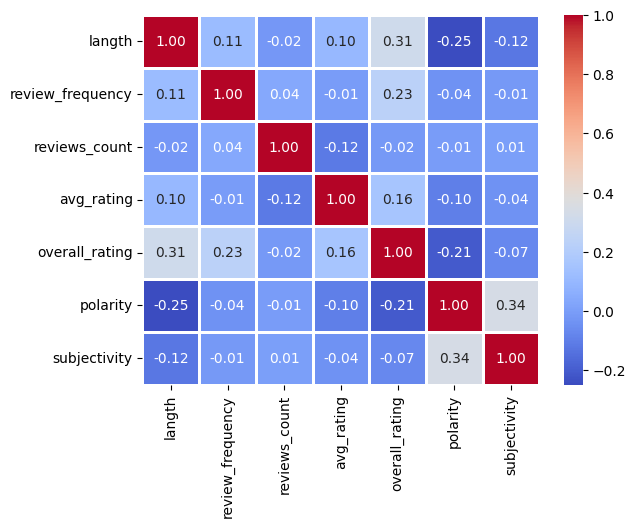

In [674]:
encoder = LabelEncoder()

enc_data = X.copy()

enc_data.drop('cleaned_reviews', axis=1, inplace=True)
# plot the heatmap
sns.heatmap(enc_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)

In [679]:
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(37740, 8)
(37740,)
(9436, 8)
(9436,)


In [680]:
model_lr = Pipeline(steps=[
    ("ColumnTransfomer",ColumnTransformer([
        ("Vectorizer",TfidfVectorizer(), 0),
        ("Identity",FunctionTransformer(), [1,2,3,4]),
    ])),
    ("Scaler",MaxAbsScaler()),
    ("Estimator",LogisticRegression())
])

In [681]:
model_lr.fit(X_train,y_train)

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ColumnTransfomer',
                 ColumnTransformer(transformers=[('Vectorizer',
                                                  TfidfVectorizer(), 0),
                                                 ('Identity',
                                                  FunctionTransformer(),
                                                  [1, 2, 3, 4])])),
                ('Scaler', MaxAbsScaler()),
                ('Estimator', LogisticRegression())])

In [682]:
pred = model_lr.predict(X_val)
print(f"Train Accuracy: {accuracy_score(y_val,pred)}")
print(f"Train F1 Score: {f1_score(y_val,pred)}")

Train Accuracy: 0.8572488342518017
Train F1 Score: 0.16074766355140188


In [375]:
model_rf = Pipeline(steps=[
    ("ColumnTransfomer",ColumnTransformer([
        ("Vectorizer",TfidfVectorizer(), 0),
        ("Identity",FunctionTransformer(), [1,2,3,4]),
    ])),
    ("Scaler",MaxAbsScaler()),
    ("Estimator",RandomForestClassifier())
])

In [376]:
model_rf.fit(X_train,y_train)

Pipeline(steps=[('ColumnTransfomer',
                 ColumnTransformer(transformers=[('Vectorizer',
                                                  TfidfVectorizer(), 0),
                                                 ('Identity',
                                                  FunctionTransformer(),
                                                  [1, 2, 3, 4])])),
                ('Scaler', MaxAbsScaler()),
                ('Estimator', RandomForestClassifier())])

In [377]:
pred = model_rf.predict(X_val)
print(f"Train Accuracy: {accuracy_score(y_val,pred)}")
print(f"Train F1 Score: {f1_score(y_val,pred)}")

Train Accuracy: 0.8672106824925816
Train F1 Score: 0.0063441712926249


In [625]:
model_xgb = Pipeline(steps=[
    ("ColumnTransfomer",ColumnTransformer([
        ("Vectorizer",TfidfVectorizer(), 0),
        ("Identity",FunctionTransformer(), [1,2,3,4]),
    ])),
    ("Scaler",MaxAbsScaler()),
    ("Estimator",XGBClassifier())
])

In [626]:
model_xgb.fit(X_train,y_train)

Pipeline(steps=[('ColumnTransfomer',
                 ColumnTransformer(transformers=[('Vectorizer',
                                                  TfidfVectorizer(), 0),
                                                 ('Identity',
                                                  FunctionTransformer(),
                                                  [1, 2, 3, 4])])),
                ('Scaler', MaxAbsScaler()),
                ('Estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [627]:
pred = model_xgb.predict(X_val)
print(f"Train Accuracy: {accuracy_score(y_val,pred)}")
print(f"Train F1 Score: {f1_score(y_val,pred)}")

Train Accuracy: 0.8681644764730818
Train F1 Score: 0.1826544021024967


In [410]:
reviewer_frequency = test_df.groupby('reviewer ID')['review ID'].count().reset_index()
reviewer_frequency.columns = ['reviewer ID', 'review_frequency']

In [411]:
ratios = test_df.groupby('reviewer ID').agg({
    'rating_Helpful': lambda x: sum(x) / len(x),
    'rating_Thanks': lambda x: sum(x) / len(x),
    'rating_LoveThis': lambda x: sum(x) / len(x),
    'review ID': 'count'
}).reset_index()
ratios.columns = ['reviewer ID', 'helpful_ratio', 'thanks_ratio', 'love_ratio', 'total_reviews']
reviewer_behavior = pd.merge(reviewer_frequency, ratios, on='reviewer ID')

In [412]:
# Calculate number of reviews per product
product_reviews_count = test_df.groupby('product ID')['review ID'].count().reset_index()
product_reviews_count.columns = ['product ID', 'reviews_count']

rating_weights = {'rating_Helpful': 1, 'rating_Thanks': 1, 'rating_LoveThis': 1, 'rating_OhNo': -1}

# Calculate overall rating for each product
test_df['overall_rating'] = test_df.apply(lambda row: sum(row[rating] * rating_weights[rating] for rating in rating_weights.keys()), axis=1)

# Calculate average rating per product
product_avg_rating = test_df.groupby('product ID')['overall_rating'].mean().reset_index()
product_avg_rating.columns = ['product ID', 'avg_rating']

# Merge the two dataframes
product_popularity = pd.merge(product_reviews_count, product_avg_rating, on='product ID')

In [415]:
# Step 1: Identify Reviewers Reviewing Multiple Products
reviewer_product_count = test_df.groupby('reviewer ID')['product ID'].nunique().reset_index()
reviewer_product_count.columns = ['reviewer ID', 'unique_products_reviewed']

# Step 2: Calculate Time Interval between Reviews
test_df['Date'] = pd.to_datetime(test_df['Date'])  # Convert Date column to datetime format
test_df_sorted = test_df.sort_values(by=['reviewer ID', 'Date'])  # Sort dataframe by reviewer ID and Date

# Calculate time difference between consecutive reviews for each reviewer
test_df_sorted['time_diff'] = test_df_sorted.groupby('reviewer ID')['Date'].diff().dt.days.fillna(0)

# Flag reviewers who submit multiple reviews within a short period (e.g., within 1 day)
short_interval_reviewers = test_df_sorted[test_df_sorted['time_diff'] < 1]['reviewer ID'].unique()

In [416]:
test_df = pd.merge(train_df, reviewer_behavior, on='reviewer ID')

In [417]:
def preprocess_df(df):
    pol = lambda x: TextBlob(x).sentiment.polarity
    sub = lambda x: TextBlob(x).sentiment.subjectivity

    df['polarity'] = df['reviews'].progress_apply(pol)
    df['subjectivity'] = df['reviews'].progress_apply(sub)

In [418]:
preprocess_df(test_df)

  0%|          | 0/18346 [00:00<?, ?it/s]

  0%|          | 0/18346 [00:00<?, ?it/s]

In [419]:
X_testt = test_df[['cleaned_reviews', 'langth', 'review_frequency', 'reviews_count', 'overall_rating']]


In [420]:
X_testt

,cleaned_reviews,langth,review_frequency,reviews_count,overall_rating
0,beautiful saturday afternoon wife home two you...,2655,3,443,-5
1,went uncommon ground brunch sunday deciding en...,794,6,294,-3
2,cigarette worthy meal revolution brewing last ...,998,1,656,-1
3,least favorite deep dish pizza chicago reading...,481,1,781,0
4,want able give [number] [number] stars love at...,930,1,645,1
...,...,...,...,...,...
18341,well understand fuss deliciousness found neigh...,923,5,949,-4
18342,excellent experiences clients family friends n...,535,5,550,-4
18343,huge fan peter parker roll also little [number...,482,1,251,-3
18344,[number] locations choose within [number] bloc...,712,3,258,-4


In [422]:
submit = pd.DataFrame()
submit["ID"] = test_df["id"] + 1
submit["Label"] = XGBClassifier.fit(X, y).predict(X_testt)

TypeError: XGBClassifier.fit() missing 1 required positional argument: 'y'